In [ ]:
import tensorflow as tf

import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display

In [ ]:
# !pip list

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data preprocessing and loading

In [ ]:
TRAIN_PATH = "drive/MyDrive/SKRIPSI/fixed_dataset/train/"
TEST_PATH = "drive/MyDrive/SKRIPSI/fixed_dataset/test/"

In [ ]:
sample_image = tf.io.read_file(TRAIN_PATH + '1310.jpg')
sample_image = tf.io.decode_jpeg(sample_image)
print(sample_image.shape)

(256, 512, 3)


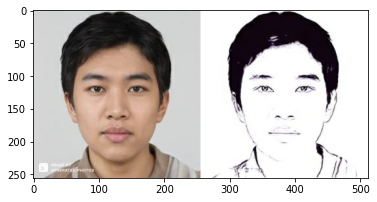

In [ ]:
plt.figure()
plt.imshow(sample_image)

In [ ]:
def load(image_file):
  # Read and decode an image file to a uint8 tensor
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)

  # Split each image tensor into two tensors:
  # - one with a real photo
  # - one with a sketch
  w = tf.shape(image)[1]
  w = w // 2
  input_sketch = image[:, w:, :]
  real_photo = image[:, :w, :]

  # Convert both images to float32 tensors
  input_sketch = tf.cast(input_sketch, tf.float32)
  real_photo = tf.cast(real_photo, tf.float32)

  return input_sketch, real_photo

In [ ]:
# The training set consist of 1355 images
BUFFER_SIZE = 1355
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

(256, 256, 3)


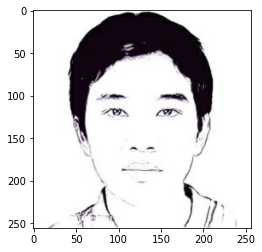

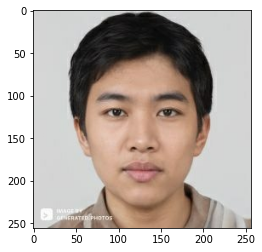

In [ ]:
inp, re = load(TRAIN_PATH + '1310.jpg')
# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(re / 255.0)
print(inp.shape)

In [ ]:
'''
Functions for dataset preprocessing purpose
'''

def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

@tf.function()
def random_jitter(input_image, real_image):
  # Resizing to 286x286
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # Random cropping back to 256x256
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

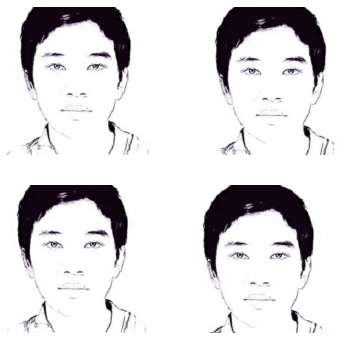

In [ ]:
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i + 1)
  plt.imshow(rj_inp / 255.0)
  plt.axis('off')
plt.show()

In [ ]:
'''
Helper functions to load training and testing dataset
'''

def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [ ]:
train_dataset = tf.data.Dataset.list_files(TRAIN_PATH + '*.jpg')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [ ]:
test_dataset = tf.data.Dataset.list_files(TEST_PATH + '*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

# Generator

In [ ]:
OUTPUT_CHANNELS = 3

In [ ]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [ ]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 128, 128, 3)


In [ ]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [ ]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


In [ ]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  encoder = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  decoder = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in encoder:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(decoder, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

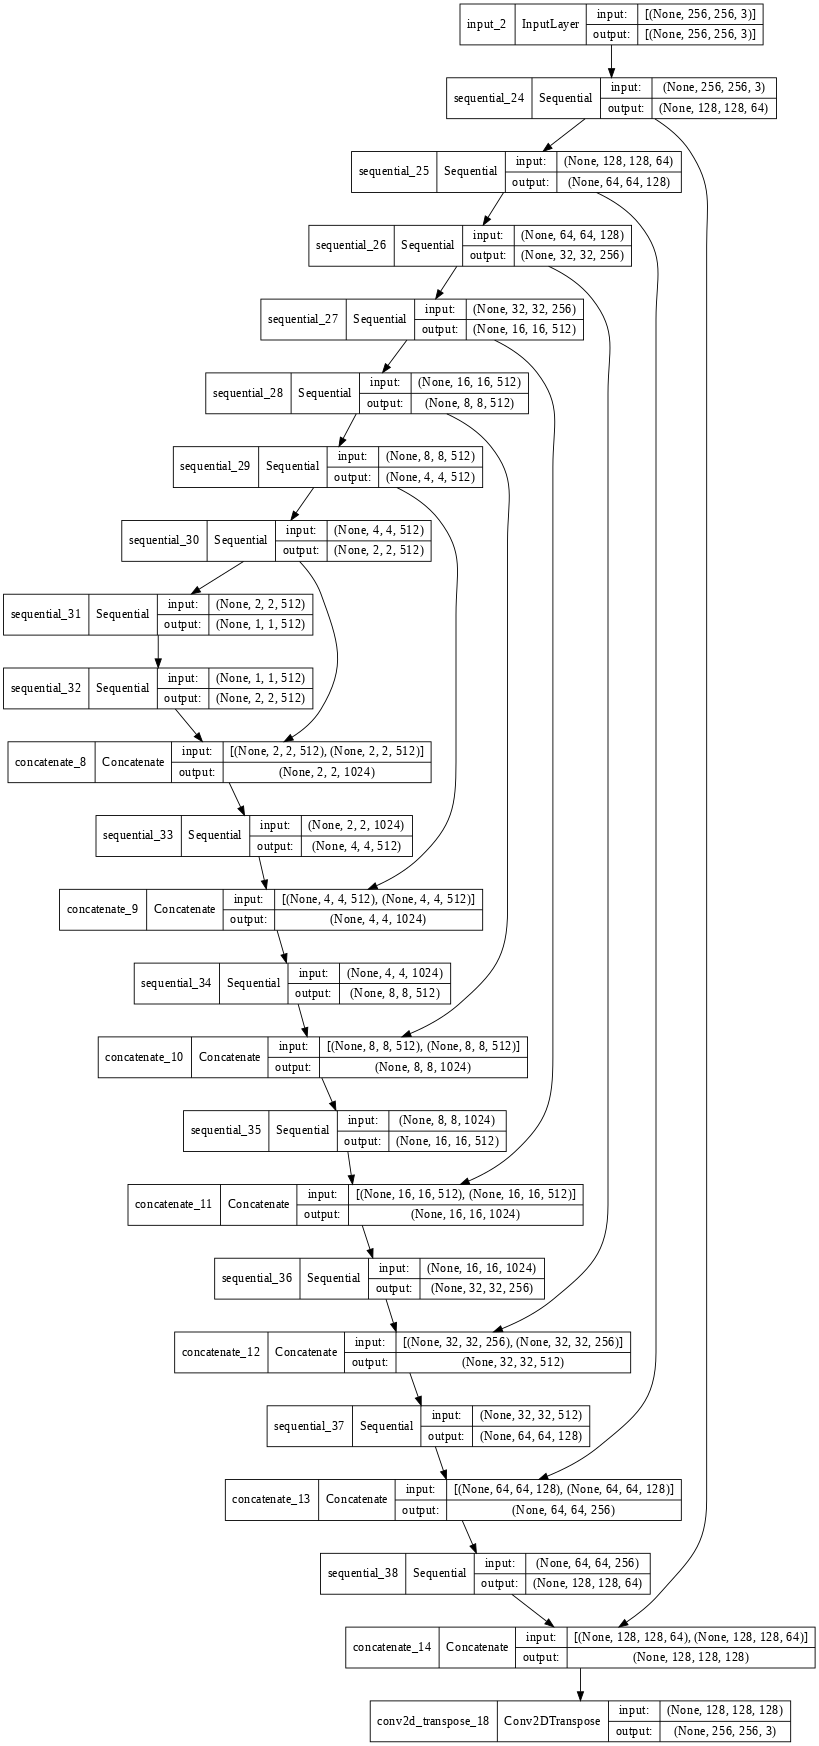

In [ ]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [ ]:
generator.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_24 (Sequential)     (None, 128, 128, 64  3072        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 sequential_25 (Sequential)     (None, 64, 64, 128)  131584      ['sequential_24[0][0]']          
                                                                                            

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


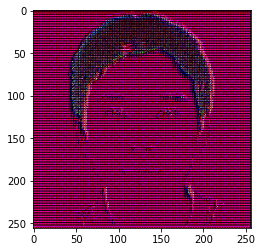

In [ ]:
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

## Generator Loss
l1_loss = MAE

**generator loss = adversarial_loss + (l1_loss * lambda)**

In [ ]:
LAMBDA = 100
TV_LAMBDA = 0.00001

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
# def generator_loss(disc_generated_output, gen_output, target):
#   gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

#   # Mean absolute error
#   l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

#   total_gen_loss = gan_loss + (LAMBDA * l1_loss)

#   return total_gen_loss, gan_loss, l1_loss

In [ ]:
def generator_loss_TV(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  # Total variation
  tv_loss = tf.reduce_sum(tf.image.total_variation(gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss) + (TV_LAMBDA * tv_loss)

  return total_gen_loss, gan_loss, l1_loss

# Discriminator

In [ ]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

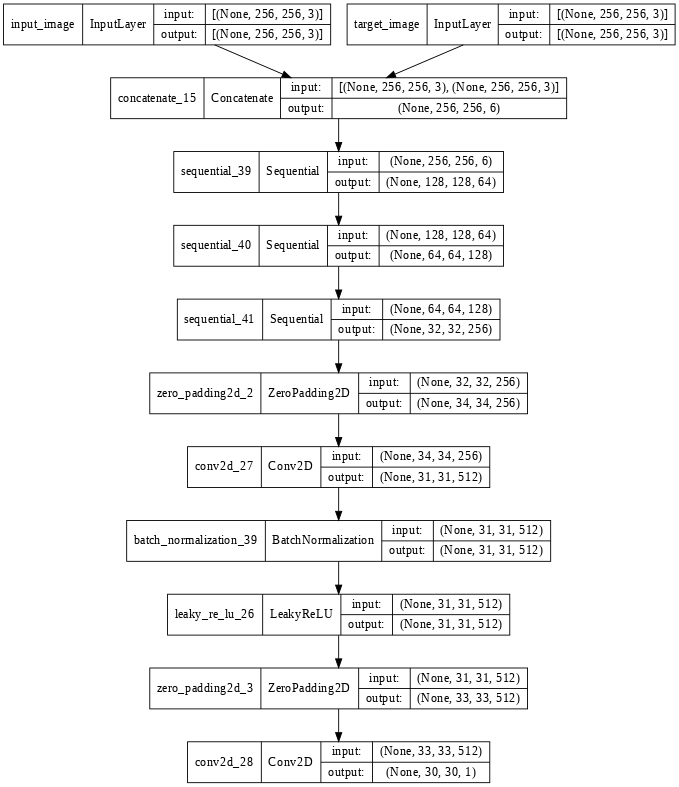

In [ ]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

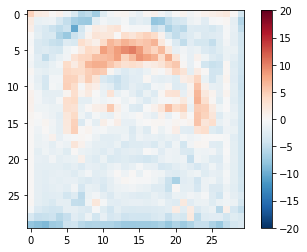

In [ ]:
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

## Discriminator Loss

**discriminator_loss = real_loss + generated_loss**

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
tv_loss = tf.reduce_sum(tf.image.total_variation(gen_output))
l1_loss = tf.reduce_mean(tf.abs(inp - gen_output))
gan_loss = loss_object(tf.ones_like(disc_out), disc_out)

print(tv_loss)
print(l1_loss)
print(gan_loss)

tf.Tensor(259306.94, shape=(), dtype=float32)
tf.Tensor(212.02654, shape=(), dtype=float32)
tf.Tensor(1.9070145, shape=(), dtype=float32)


# Checkpoint

In [ ]:
checkpoint_dir = "drive/MyDrive/SKRIPSI/fixed_dataset/checkpoint/"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Visual

In [ ]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

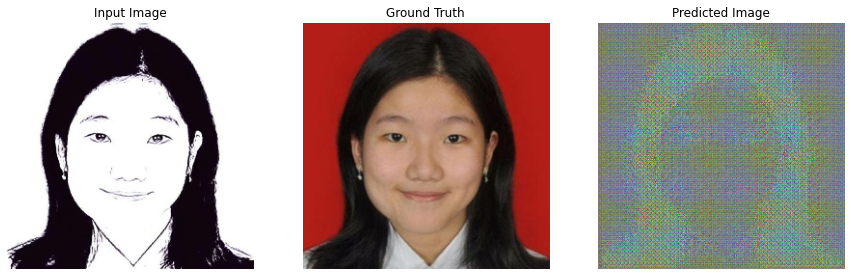

In [ ]:
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

# Training

In [ ]:
log_dir="drive/MyDrive/SKRIPSI/fixed_dataset/logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss_TV(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

In [ ]:
def fit(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    # if (step + 1) % 5000 == 0:
    #   checkpoint.save(file_prefix=checkpoint_prefix)

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir {log_dir}

Time taken for 1000 steps: 181.81 sec



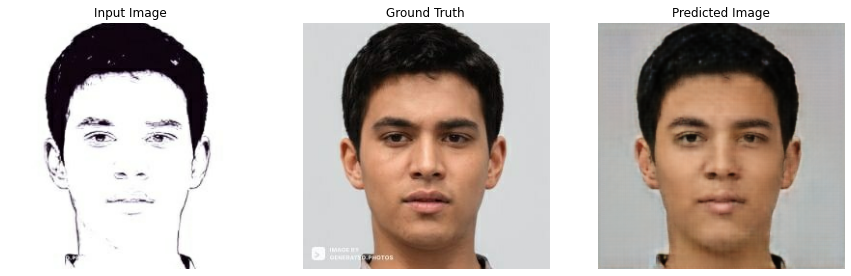

Step: 39k
....................................................................................................

In [ ]:
fit(train_dataset, test_dataset, steps=40000)

# Restore Checkpoint

In [ ]:
ls {checkpoint_dir}

ls: cannot access 'drive/MyDrive/SKRIPSI/fixed_dataset/checkpoint/': No such file or directory


In [ ]:
# Restoring the latest checkpoint in checkpoint_dir
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

# Generate image using generator

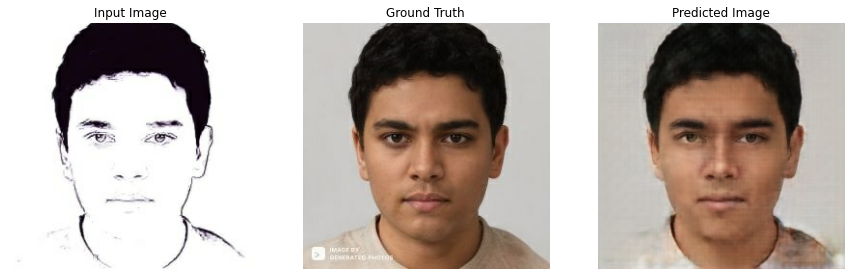

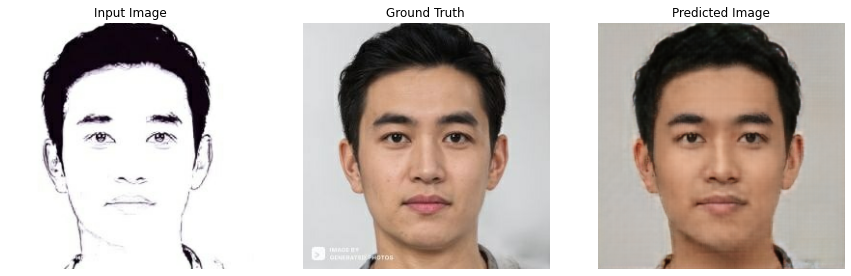

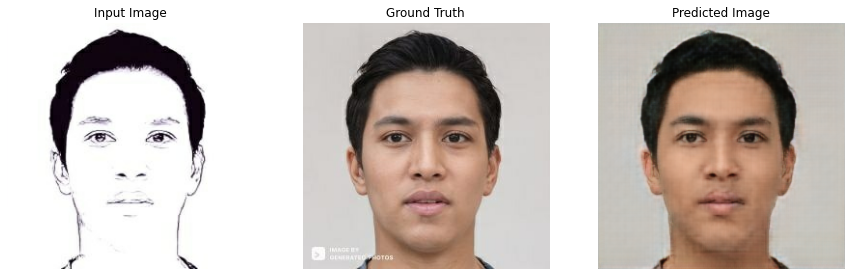

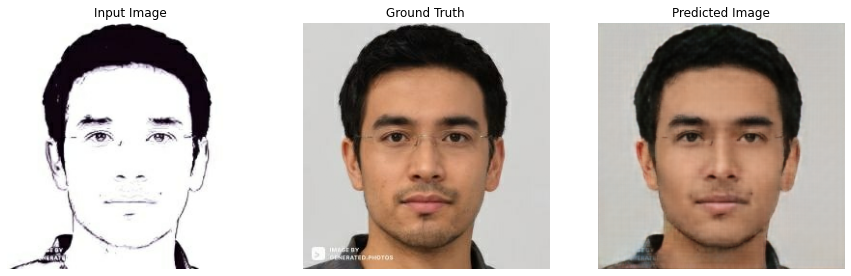

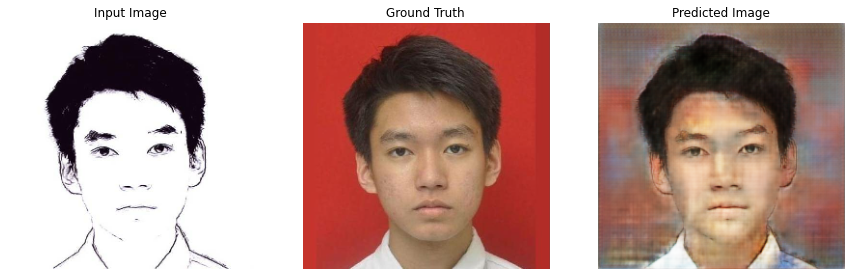

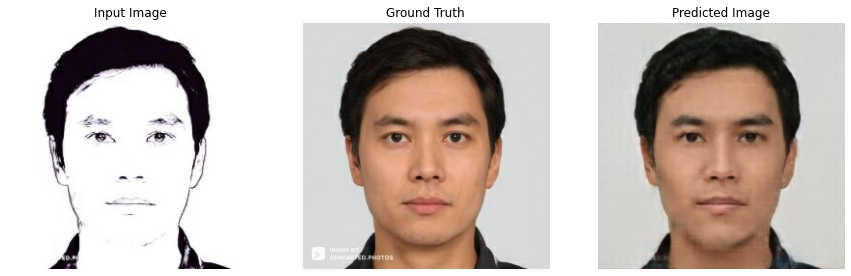

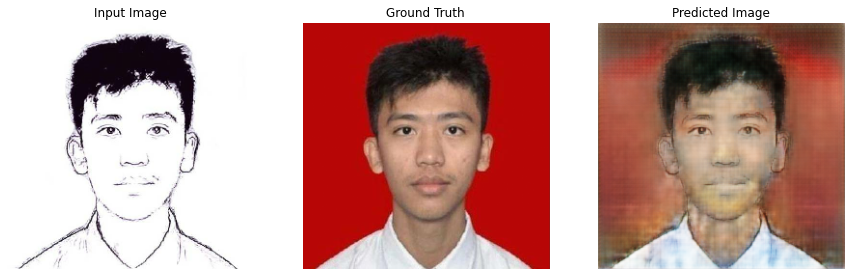

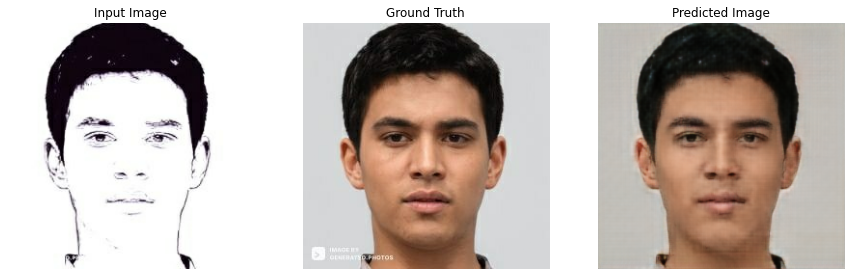

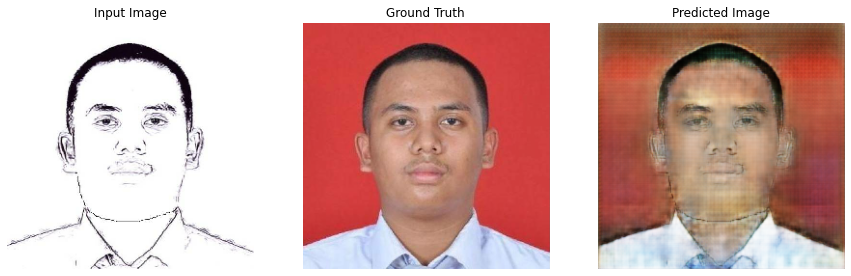

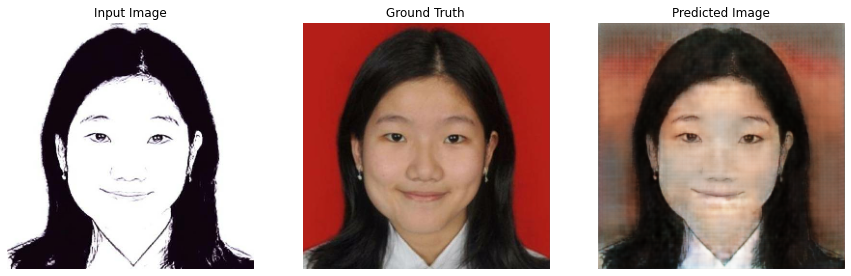

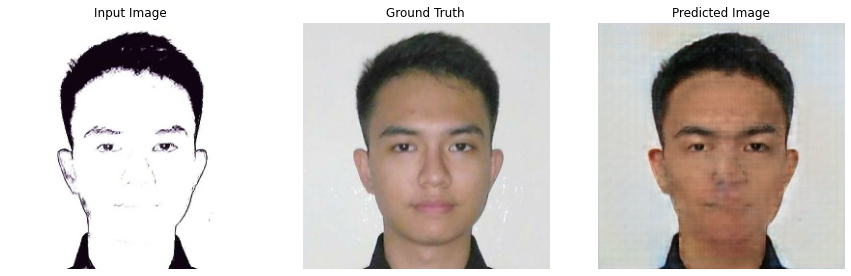

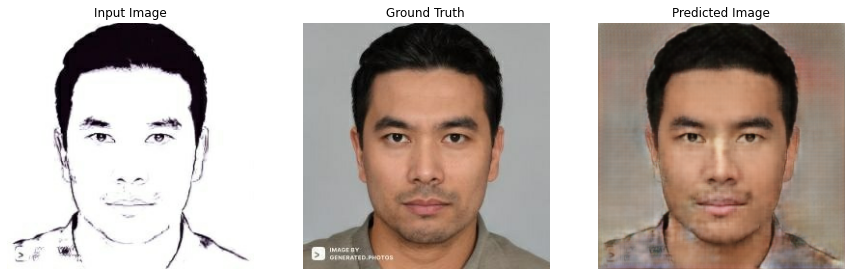

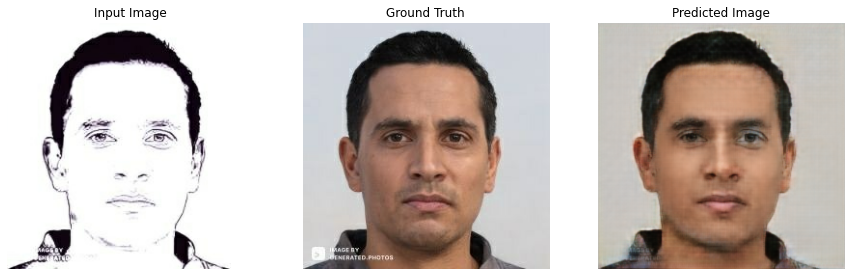

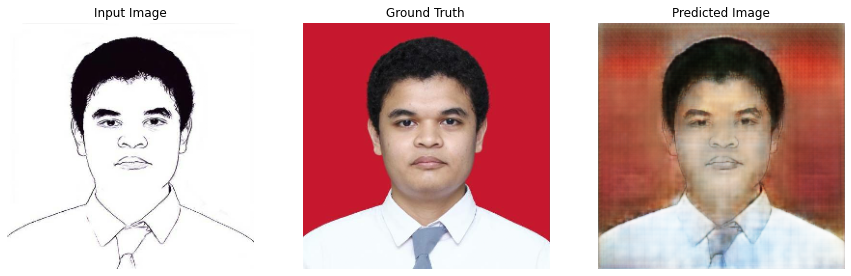

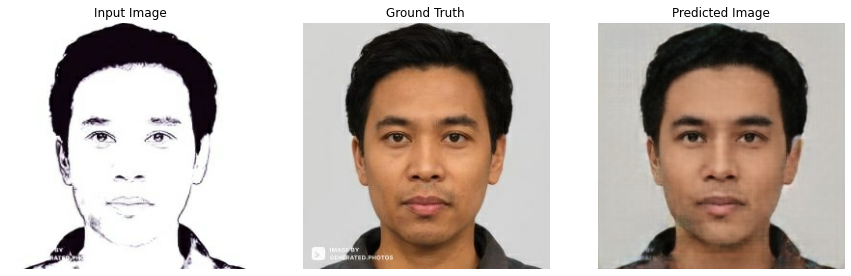

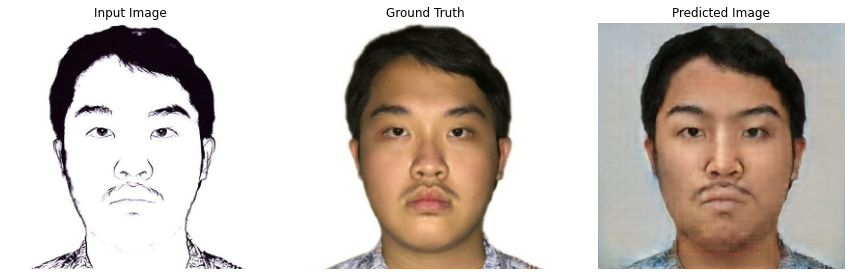

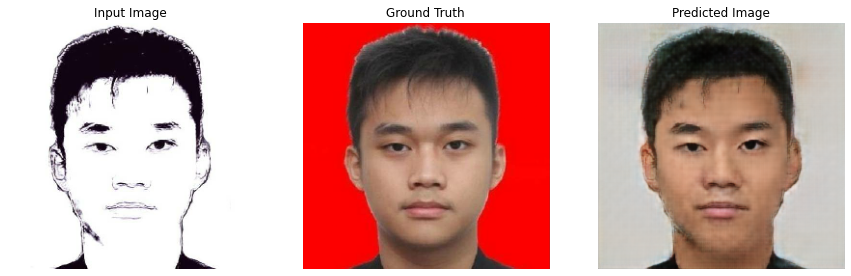

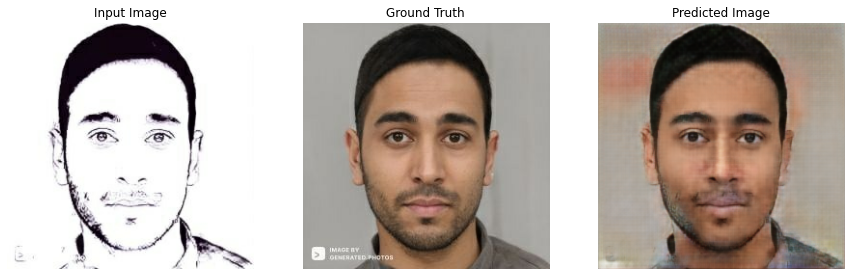

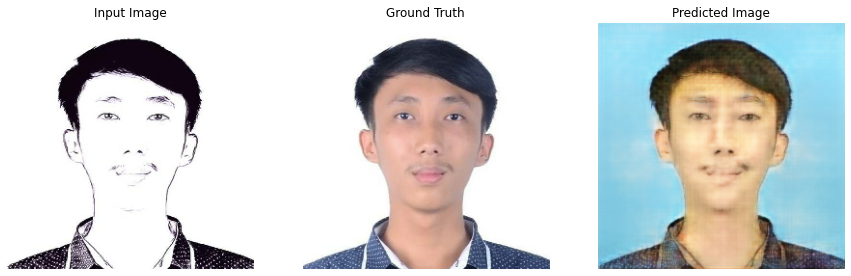

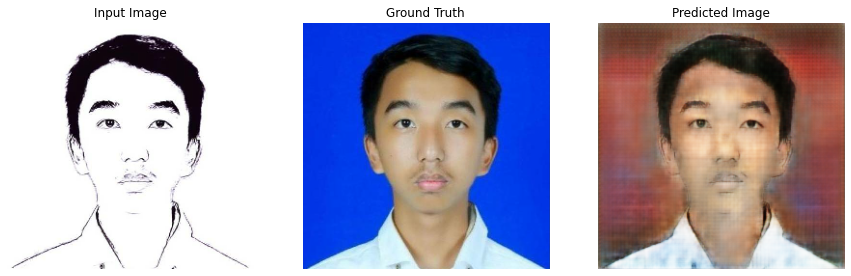

In [ ]:
for inp, tar in test_dataset.take(-1):
  generate_images(generator, inp, tar)

# Exporting

In [ ]:
print(type(generator))

<class 'keras.engine.functional.Functional'>


In [ ]:
# Save using standard format
generator.save("drive/MyDrive/SKRIPSI/fixed_dataset/generatornya/unetGenerator")

INFO:tensorflow:Assets written to: drive/MyDrive/SKRIPSI/fixed_dataset/generatornya/unetGenerator/assets


In [ ]:
new_testing_generator = tf.keras.models.load_model("drive/MyDrive/SKRIPSI/fixed_dataset/generatornya/unetGenerator")

In [ ]:
for inp, tar in test_dataset.take(2):
  generate_images(new_testing_generator, inp, tar)

(1, 256, 256, 3)
(1, 256, 256, 3)


In [ ]:
# Saved using HDF5 format
generator.save("drive/MyDrive/SKRIPSI/GANs/100_0.00001v3/generator.h5")

# Test Saved Generator



In [ ]:
def preprocess_image(image_file):
    # Read and decode an image file to a uint8 tensor
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)

    # Convert both images to float32 tensors
    input_sketch = tf.cast(image, tf.float32)

    # Resize to the coressponding size
    input_sketch = tf.image.resize(input_sketch, [256, 256],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    # Normalize
    input_sketch = (input_sketch / 127.5) - 1
    input_sketch = tf.expand_dims(input_sketch, 0)

    return input_sketch

def generate_and_plot(model, image_file):
    input_sketch = preprocess_image(image_file)
    prediction = model(input_sketch, training=True)
    plt.imshow(prediction[0] * 0.5 + 0.5)

In [ ]:
hdf5_generator = tf.keras.models.load_model("drive/MyDrive/SKRIPSI/GANs/0.01_0.00001/generator.h5")

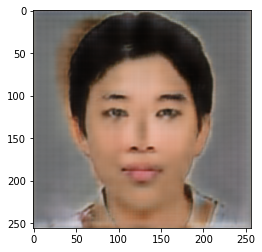

In [ ]:
generate_and_plot(hdf5_generator, "drive/MyDrive/SKRIPSI/fixed_dataset/fixed_sketches/1310.jpg")

In [ ]:
for inp, tar in test_dataset.take(10):
  generate_images(hdf5_generator, inp, tar)

# TENSORBOARD

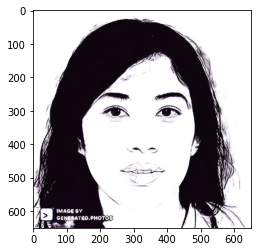

In [ ]:
# Image Loading Code used for these examples
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
img = Image.open('0002.jpeg')
img = np.array(img)




plt.imshow(img)
plt.show()

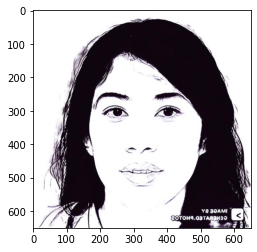

In [ ]:
flipped_img = np.fliplr(img)
plt.imshow(flipped_img)
plt.show()

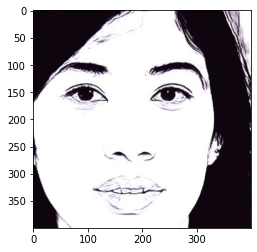

In [ ]:
image_cropped = img[150:550, 150:550]
plt.imshow(image_cropped)
plt.show()

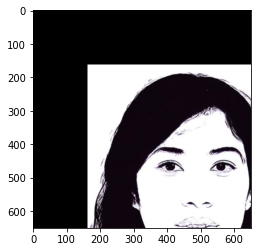

In [ ]:
height, width = img.shape[:2]
# create the translation matrix
tx, ty = width / 4, height / 4
translation_matrix = np.float32([
    [1, 0, tx],
    [0, 1, ty]
])
# apply translation
final_size = (width, height)
image_translated = cv2.warpAffine(
    img, translation_matrix, final_size
)
plt.imshow(image_translated)
plt.show()

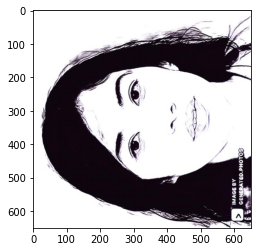

In [ ]:
rotation_matrix = cv2.getRotationMatrix2D(
    (width / 2, height / 2), 90, 1
)
# rotate the image
image_rotated = cv2.warpAffine(
    img, rotation_matrix, (width, height)
)

plt.imshow(image_rotated)
plt.show()

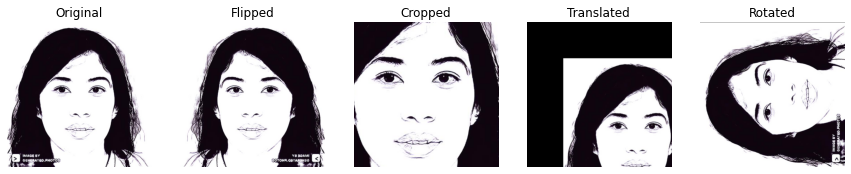

In [ ]:
# Image Loading Code used for these examples
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
img = Image.open('0002.jpeg')
img = np.array(img)

image_flipped = np.fliplr(img)

image_cropped = img[150:550, 150:550]

height, width = img.shape[:2]
# create the translation matrix
tx, ty = width / 4, height / 4
translation_matrix = np.float32([
    [1, 0, tx],
    [0, 1, ty]
])
# apply translation
final_size = (width, height)
image_translated = cv2.warpAffine(
    img, translation_matrix, final_size
)


rotation_matrix = cv2.getRotationMatrix2D(
    (width / 2, height / 2), 90, 1
)
# rotate the image
image_rotated = cv2.warpAffine(
    img, rotation_matrix, (width, height)
)


plt.figure(figsize=(15, 15))

display_list = [img, image_flipped, image_cropped, image_translated, image_rotated]
title = ['Original', 'Flipped', 'Cropped', 'Translated', 'Rotated']

for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i])
    plt.axis('off')
plt.show()